<a href="https://colab.research.google.com/github/hammadkhann/Towards-reducing-the-storage-cost-of-late-interation-reranker/blob/main/Neural_Reranking(RD1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pyterrier Setup**

In [1]:
!pip -q install python-terrier
import pyterrier as pt
pt.init()

     |████████████████████████████████| 95 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 31.6 MB/s 
     |████████████████████████████████| 69 kB 7.4 MB/s 
     |████████████████████████████████| 255 kB 42.7 MB/s 
     |████████████████████████████████| 1.8 MB 35.1 MB/s 
     |████████████████████████████████| 294 kB 49.6 MB/s 
     |████████████████████████████████| 6.3 MB 32.7 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 126 kB 43.4 MB/s 
     |████████████████████████████████| 291 kB 50.2 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.7.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


## **Importing useful libraries**



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from google.colab import drive
from pyterrier.measures import *

pd.options.display.max_rows = None
pd.options.display.max_columns = None

## **Connect Google Drive**


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparing testing dataset**

## **DPH(Sparse Retrieval)**

## TREC-2019

In [4]:
br = pt.BatchRetrieve.from_dataset('msmarco_passage', 'terrier_stemmed_text', num_results=100, metadata = ['docno', 'text'], verbose=True)

/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:273: UserWarning: Downloading index of > 2GB.
  warn("Downloading index of > 2GB.")


data.direct.bf:   0%|          | 0.00/486M [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/177M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/377M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/100M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/4.47M [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/295M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/67.5M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/1.91G [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.33k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/537 [00:00<?, ?iB/s]

19:02:15.832 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


In [5]:
dph_2019 = pd.DataFrame()
topics = pt.get_dataset('msmarco_passage').get_topics('test-2019')
topics = pt.get_dataset('msmarco_passage').get_qrels('test-2019')[["qid"]].drop_duplicates().merge(topics, on=['qid'])
for res in br.transform_gen(topics, batch_size=10):
  dph_2019 = dph_2019.append(res)
print("Number of topics: ", len(topics))

msmarco-test2019-queries.tsv.gz:   0%|          | 0.00/4.18k [00:00<?, ?iB/s]

2019qrels-docs.txt:   0%|          | 0.00/183k [00:00<?, ?iB/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/3 [00:00<?, ?q/s]

Number of topics:  43


In [6]:
dph_2019.shape

(4205, 7)

## TREC-2020

In [7]:
dph_2020 = pd.DataFrame()
topics = pt.get_dataset('msmarco_passage').get_topics('test-2020')
topics = pt.get_dataset('msmarco_passage').get_qrels('test-2020')[["qid"]].drop_duplicates().merge(topics, on=['qid'])
for res in br.transform_gen(topics, batch_size=10):
  dph_2020 = dph_2020.append(res)
  
print("Number of topics: ", len(topics))

msmarco-test2020-queries.tsv.gz:   0%|          | 0.00/4.03k [00:00<?, ?iB/s]

2020qrels-docs.txt:   0%|          | 0.00/213k [00:00<?, ?iB/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/10 [00:00<?, ?q/s]

BR(DPH):   0%|          | 0/4 [00:00<?, ?q/s]

Number of topics:  54


In [8]:
dph_2020.shape

(5329, 7)

## **ColBERT(Dense Retrieval)**

## TREC-2019

In [9]:
index = pt.IndexFactory.of(pt.get_dataset("msmarco_passage").get_index("terrier_stemmed_text"))
print(index.getCollectionStatistics())

19:02:28.646 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
Number of documents: 8841823
Number of terms: 1170682
Number of postings: 215238456
Number of fields: 1
Number of tokens: 288759529
Field names: [text]
Positions:   false



In [10]:
colbert_2019 = pt.io.read_results("/content/drive/MyDrive/E2E.2019.res")
# get document text for each docid
meta = index.getMetaIndex()
text = []
for index, row in colbert_2019.iterrows():
    text.append(meta.getItem('text', int(row['docno'])))
colbert_2019['text'] = text

# get query for each qid
topics_2019 = pt.get_dataset('msmarco_passage').get_topics('test-2019')
colbert_2019 = pd.merge(colbert_2019, topics_2019, on='qid', how='left')

# filter queries on 43 topics
colbert_2019 = colbert_2019[colbert_2019['qid'].isin(dph_2019['qid'].unique())]
# filter data on top100 results for each 43 topics
colbert_2019 = colbert_2019.groupby('qid').apply(lambda x : x.sort_values(by = 'score', ascending = False).head(100).reset_index(drop = True))
# reset index
colbert_2019.reset_index(drop=True, inplace=True)
colbert_2019.shape

(4300, 7)

## TREC-2020

In [11]:
colbert_2020 = pt.io.read_results("/content/drive/MyDrive/E2E.2020.res")
index = pt.IndexFactory.of(pt.get_dataset("msmarco_passage").get_index("terrier_stemmed_text"))

# get document text for each docid
meta = index.getMetaIndex()
text = []
for index, row in colbert_2020.iterrows():
    text.append(meta.getItem('text', int(row['docno'])))
colbert_2020['text'] = text

# get query for each qid
topics_2020 = pt.get_dataset('msmarco_passage').get_topics('test-2020')
colbert_2020 = pd.merge(colbert_2020, topics_2020, on='qid', how='left')

# filter queries on 43 topics
colbert_2020 = colbert_2020[colbert_2020['qid'].isin(dph_2020['qid'].unique())]
# filter data on top100 results for each 43 topics
colbert_2020 = colbert_2020.groupby('qid').apply(lambda x : x.sort_values(by = 'score', ascending = False).head(100).reset_index(drop = True))
# reset index
colbert_2020.reset_index(drop=True, inplace=True)
colbert_2020.shape

19:03:41.622 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


(5400, 7)

# **Pyterrier-ColBERT Setup**

In [12]:
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_colbert.git

  Cloning https://github.com/terrierteam/pyterrier_colbert.git to /tmp/pip-req-build-q0lludsp
  Running command git clone -q https://github.com/terrierteam/pyterrier_colbert.git /tmp/pip-req-build-q0lludsp
  Cloning https://github.com/cmacdonald/ColBERT.git (to revision v0.2) to /tmp/pip-install-ogij0f1c/colbert_899408beef0f42fb93652c21ef3b4dc2
  Running command git clone -q https://github.com/cmacdonald/ColBERT.git /tmp/pip-install-ogij0f1c/colbert_899408beef0f42fb93652c21ef3b4dc2
  Running command git checkout -b v0.2 --track origin/v0.2
  Switched to a new branch 'v0.2'
  Branch 'v0.2' set up to track remote branch 'v0.2' from 'origin'.
     |████████████████████████████████| 769 kB 5.5 MB/s 
     |████████████████████████████████| 216 kB 49.7 MB/s 
     |████████████████████████████████| 15.5 MB 27.5 MB/s 
     |████████████████████████████████| 3.0 MB 37.0 MB/s 
     |████████████████████████████████| 1.2 MB 35.6 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
    

In [13]:
from pyterrier_colbert.ranking import ColBERTFactory

## Updating pyterrier-ColBERT load methods to support latest version of transformers library.

In [14]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/Luyu/condenser

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 52 not upgraded.
Need to get 6,526 kB of archives.
After this operation, 14.7 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.0.2 [6,526 kB]
Fetched 6,526 kB in 1s (11.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [15]:
import os
import ujson
import torch
import random

from collections import defaultdict, OrderedDict

from colbert.parameters import DEVICE
import colbert.utils.utils
from colbert.utils.utils import print_message


def _load_checkpoint(path, model, optimizer=None, do_print=True):
    if do_print:
        print_message("#> Loading checkpoint", path)

    checkpoint = torch.load(path, map_location='cpu')

    state_dict = checkpoint['model_state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if k[:7] == 'module.':
            name = k[7:]
        new_state_dict[name] = v

    checkpoint['model_state_dict'] = new_state_dict

    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'], strict=False)

    if do_print:
        print_message("#> checkpoint['epoch'] =", checkpoint['epoch'])
        print_message("#> checkpoint['batch'] =", checkpoint['batch'])

    return checkpoint

colbert.utils.utils.load_checkpoint = _load_checkpoint
colbert.utils.utils.load_checkpoint.__globals__['load_checkpoint'] = _load_checkpoint
from colbert.modeling.colbert import ColBERT

def _load_model(args, do_print=True):
    colbert = ColBERT.from_pretrained('/content/condenser/',
                                      query_maxlen=args.query_maxlen,
                                      doc_maxlen=args.doc_maxlen,
                                      dim=args.dim,
                                      similarity_metric=args.similarity,
                                      mask_punctuation=args.mask_punctuation)
    colbert = colbert.to(DEVICE)

    print_message("#> Loading model checkpoint.", condition=do_print)

    checkpoint = load_checkpoint(args.checkpoint, colbert, do_print=do_print)

    colbert.eval()

    return colbert, checkpoint

In [16]:
import colbert.evaluation.load_model
import pyterrier_colbert.ranking
colbert.evaluation.load_model.load_model = _load_model
pyterrier_colbert.ranking.load_model = _load_model

# **Evaluation on TREC 2019**

## **Loading model checkpoints**

### Baseline

In [17]:
colbert_checkpoint="/content/drive/MyDrive/colbert-baseline-50000.dnn" 
colbert_factory = ColBERTFactory(colbert_checkpoint, None, None)
colbert_pipeline_ann = pt.transformer.SourceTransformer(colbert_2019) >>  colbert_factory.text_scorer()
colbert_pipeline = pt.transformer.SourceTransformer(dph_2019) >>  colbert_factory.text_scorer()

/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:233: UserWarning: No index_root and index_name specified - no index ranking possible
  warn("No index_root and index_name specified - no index ranking possible")
/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:249: UserWarning: Faiss not installed. You cannot do retrieval
  warn("Faiss not installed. You cannot do retrieval")
Some weights of the model checkpoint at /content/condenser/ were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

[Dec 05, 19:06:16] #> Loading model checkpoint.
[Dec 05, 19:06:16] #> Loading checkpoint /content/drive/MyDrive/colbert-baseline-50000.dnn
[Dec 05, 19:06:35] #> checkpoint['epoch'] = 0
[Dec 05, 19:06:35] #> checkpoint['batch'] = 50000


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

### RD1: Additional signal during ColBERT training

In [18]:
cls_similarity_checkpoint="/content/drive/MyDrive/colbert-increase-cls-similarity-50000.dnn" 
cls_similarity_factory = ColBERTFactory(cls_similarity_checkpoint, None, None)
cls_similarity_pipeline_ann = pt.transformer.SourceTransformer(colbert_2019) >>  cls_similarity_factory.text_scorer()
cls_similarity_pipeline = pt.transformer.SourceTransformer(dph_2019) >>  cls_similarity_factory.text_scorer()

/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:233: UserWarning: No index_root and index_name specified - no index ranking possible
  warn("No index_root and index_name specified - no index ranking possible")
/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:249: UserWarning: Faiss not installed. You cannot do retrieval
  warn("Faiss not installed. You cannot do retrieval")
Some weights of the model checkpoint at /content/condenser/ were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

[Dec 05, 19:06:41] #> Loading model checkpoint.
[Dec 05, 19:06:41] #> Loading checkpoint /content/drive/MyDrive/colbert-increase-cls-similarity-50000.dnn
[Dec 05, 19:07:04] #> checkpoint['epoch'] = 0
[Dec 05, 19:07:04] #> checkpoint['batch'] = 50000


In [19]:
token_overlap_checkpoint="/content/drive/MyDrive/colbert-token-overlap-50000.dnn" 
token_overlap_factory = ColBERTFactory(token_overlap_checkpoint, None, None)
token_overlap_pipeline_ann = pt.transformer.SourceTransformer(colbert_2019) >>  token_overlap_factory.text_scorer()
token_overlap_pipeline = pt.transformer.SourceTransformer(dph_2019) >>  token_overlap_factory.text_scorer()

/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:233: UserWarning: No index_root and index_name specified - no index ranking possible
  warn("No index_root and index_name specified - no index ranking possible")
/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:249: UserWarning: Faiss not installed. You cannot do retrieval
  warn("Faiss not installed. You cannot do retrieval")
Some weights of the model checkpoint at /content/condenser/ were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

[Dec 05, 19:07:08] #> Loading model checkpoint.
[Dec 05, 19:07:08] #> Loading checkpoint /content/drive/MyDrive/colbert-token-overlap-50000.dnn
[Dec 05, 19:07:42] #> checkpoint['epoch'] = 0
[Dec 05, 19:07:42] #> checkpoint['batch'] = 50000


## **Experiment**

### DPH(Sparse Retrieval) Re-ranking

In [20]:
pt.Experiment(
    [colbert_pipeline, cls_similarity_pipeline, token_overlap_pipeline],
    pt.get_dataset('msmarco_passage').get_topics('test-2019'),
    pt.get_dataset('msmarco_passage').get_qrels('test-2019'),
    filter_by_qrels=True,
    names=['DPH >> ColBERT', 'DPH >> ColBERT-increase-cls-similarity', 'DPH >> ColBERT-add-token-overlap'],
    eval_metrics= [nDCG@10, AP(rel=2)@100, RR(rel=2)@10]
)

,name,nDCG@10,AP(rel=2)@100,RR(rel=2)@10
0,DPH >> ColBERT,0.668218,0.340573,0.832226
1,DPH >> ColBERT-increase-cls-similarity,0.670897,0.342530,0.841307
2,DPH >> ColBERT-add-token-overlap,0.666822,0.340682,0.810299


### ColBERT(Dense Retrieval) Re-ranking

In [21]:
pt.Experiment(
    [colbert_pipeline_ann, cls_similarity_pipeline_ann, token_overlap_pipeline_ann],
    pt.get_dataset('msmarco_passage').get_topics('test-2019'),
    pt.get_dataset('msmarco_passage').get_qrels('test-2019'),
    filter_by_qrels=True,
    names=['ANN-ColBERT >> ColBERT', 'ANN-ColBERT >> ColBERT-increase-cls-similarity', 'ANN-ColBERT >> ColBERT-add-token-overlap'],
    eval_metrics= [nDCG@10, AP(rel=2)@100, RR(rel=2)@10]
)

,name,nDCG@10,AP(rel=2)@100,RR(rel=2)@10
0,ANN-ColBERT >> ColBERT,0.719955,0.396942,0.877907
1,ANN-ColBERT >> ColBERT-increase-cls-similarity,0.711017,0.402417,0.870155
2,ANN-ColBERT >> ColBERT-add-token-overlap,0.671373,0.383359,0.825581


# **Evaluation on TREC 2020**

## **Loading model checkpoints**

### Baseline 

In [22]:
colbert_pipeline_ann_2020 = pt.transformer.SourceTransformer(colbert_2020) >>  colbert_factory.text_scorer()
colbert_pipeline_2020 = pt.transformer.SourceTransformer(dph_2020) >>  colbert_factory.text_scorer()

### RD1: Additional signal during ColBERT training

In [23]:
cls_similarity_pipeline_ann_2020 = pt.transformer.SourceTransformer(colbert_2020) >>  cls_similarity_factory.text_scorer()
cls_similarity_pipeline_2020 = pt.transformer.SourceTransformer(dph_2020) >>  cls_similarity_factory.text_scorer()

In [24]:
token_overlap_pipeline_ann_2020 = pt.transformer.SourceTransformer(colbert_2020) >>  token_overlap_factory.text_scorer()
token_overlap_pipeline_2020 = pt.transformer.SourceTransformer(dph_2020) >>  token_overlap_factory.text_scorer()

## **Experiment**

### DPH(Sparse Retrieval) Re-ranking

In [25]:
pt.Experiment(
    [colbert_pipeline_2020, cls_similarity_pipeline_2020, token_overlap_pipeline_2020],
    pt.get_dataset('msmarco_passage').get_topics('test-2020'),
    pt.get_dataset('msmarco_passage').get_qrels('test-2020'),
    filter_by_qrels=True,
    names=['DPH >> ColBERT', 'DPH >> ColBERT-increase-cls-similarity', 'DPH >> ColBERT-add-token-overlap'],
    eval_metrics= [nDCG@10, AP(rel=2)@100, RR(rel=2)@10]
)

,name,nDCG@10,AP(rel=2)@100,RR(rel=2)@10
0,DPH >> ColBERT,0.664682,0.395361,0.851235
1,DPH >> ColBERT-increase-cls-similarity,0.662280,0.395247,0.833333
2,DPH >> ColBERT-add-token-overlap,0.655973,0.401742,0.833848


### ColBERT(Dense Retrieval) Re-ranking

In [26]:
pt.Experiment(
    [colbert_pipeline_ann_2020, cls_similarity_pipeline_ann_2020, token_overlap_pipeline_ann_2020],
    pt.get_dataset('msmarco_passage').get_topics('test-2020'),
    pt.get_dataset('msmarco_passage').get_qrels('test-2020'),
    filter_by_qrels=True,
    names=['ANN-ColBERT >> ColBERT', 'ANN-ColBERT >> ColBERT-increase-cls-similarity', 'ANN-ColBERT >> ColBERT-add-token-overlap'],
    eval_metrics= [nDCG@10, AP(rel=2)@100, RR(rel=2)@10]
)

,name,nDCG@10,AP(rel=2)@100,RR(rel=2)@10
0,ANN-ColBERT >> ColBERT,0.690310,0.449931,0.844136
1,ANN-ColBERT >> ColBERT-increase-cls-similarity,0.690331,0.446808,0.824735
2,ANN-ColBERT >> ColBERT-add-token-overlap,0.671862,0.439425,0.803417


# **Per-Query Effectiveness on TREC-2019**

In [27]:
bs_df = pt.Experiment(
    [colbert_pipeline_ann],
    pt.get_dataset('msmarco_passage').get_topics('test-2019'),
    pt.get_dataset('msmarco_passage').get_qrels('test-2019'),
    names=['ANN-ColBERT >> ColBERT'],
    filter_by_qrels=True,
    eval_metrics=[nDCG@10],
    perquery=True
)

In [28]:
cls_similarity_df = pt.Experiment(
    [cls_similarity_pipeline_ann],
    pt.get_dataset('msmarco_passage').get_topics('test-2019'),
    pt.get_dataset('msmarco_passage').get_qrels('test-2019'),
    names=['ANN-ColBERT >> ColBERT-increase-cls-similarity'],
    filter_by_qrels=True,
    eval_metrics=[nDCG@10],
    perquery=True
) 

In [29]:
bs_df = bs_df[bs_df['value'].notnull()]
cls_similarity_df = cls_similarity_df[cls_similarity_df['value'].notnull()]
td_df = pt.get_dataset('msmarco_passage').get_topics('test-2019')

In [31]:
cls_similarity_df["delta"] = cls_similarity_df["value"] - bs_df["value"]
cls_similarity_df.head(5)

,name,qid,measure,value,delta
0,ANN-ColBERT >> ColBERT-increase-cls-similarity,1037798,nDCG@10,0.373673,-0.004662
1,ANN-ColBERT >> ColBERT-increase-cls-similarity,104861,nDCG@10,0.779908,-0.004709
2,ANN-ColBERT >> ColBERT-increase-cls-similarity,1063750,nDCG@10,0.348965,-0.087113
3,ANN-ColBERT >> ColBERT-increase-cls-similarity,1103812,nDCG@10,0.594223,-0.074563
4,ANN-ColBERT >> ColBERT-increase-cls-similarity,1106007,nDCG@10,0.599679,-0.084159


In [32]:
cls_similarity_df = pd.merge(cls_similarity_df,td_df, how='left', on='qid')
sorted_cls_similarity_df = cls_similarity_df.sort_values("delta", ascending=False)
sorted_cls_similarity_df["qid:query"] = sorted_cls_similarity_df["qid"] + ":" + sorted_cls_similarity_df["query"]

In [33]:
sorted_cls_similarity_df.head(10)

,name,qid,measure,value,delta,query,qid:query
36,ANN-ColBERT >> ColBERT-increase-cls-similarity,573724,nDCG@10,0.798237,0.120074,what are the social determinants of health,573724:what are the social determinants of health
17,ANN-ColBERT >> ColBERT-increase-cls-similarity,130510,nDCG@10,0.906890,0.090435,definition declaratory judgment,130510:definition declaratory judgment
20,ANN-ColBERT >> ColBERT-increase-cls-similarity,148538,nDCG@10,0.611147,0.090112,difference between rn and bsn,148538:difference between rn and bsn
19,ANN-ColBERT >> ColBERT-increase-cls-similarity,146187,nDCG@10,0.960602,0.078786,difference between a mcdouble and a double che...,146187:difference between a mcdouble and a dou...
15,ANN-ColBERT >> ColBERT-increase-cls-similarity,1129237,nDCG@10,0.571615,0.072588,hydrogen is a liquid below what temperature,1129237:hydrogen is a liquid below what temper...
35,ANN-ColBERT >> ColBERT-increase-cls-similarity,527433,nDCG@10,0.647486,0.049813,types of dysarthria from cerebral palsy,527433:types of dysarthria from cerebral palsy
26,ANN-ColBERT >> ColBERT-increase-cls-similarity,207786,nDCG@10,0.623564,0.045102,how are some sharks warm blooded,207786:how are some sharks warm blooded
12,ANN-ColBERT >> ColBERT-increase-cls-similarity,1121402,nDCG@10,1.000000,0.031810,what can contour plowing reduce,1121402:what can contour plowing reduce
38,ANN-ColBERT >> ColBERT-increase-cls-similarity,855410,nDCG@10,0.908221,0.029546,what is theraderm used for,855410:what is theraderm used for
8,ANN-ColBERT >> ColBERT-increase-cls-similarity,1114646,nDCG@10,0.815229,0.023604,what is famvir prescribed for,1114646:what is famvir prescribed for


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 <a list of 43 Text major ticklabel objects>)

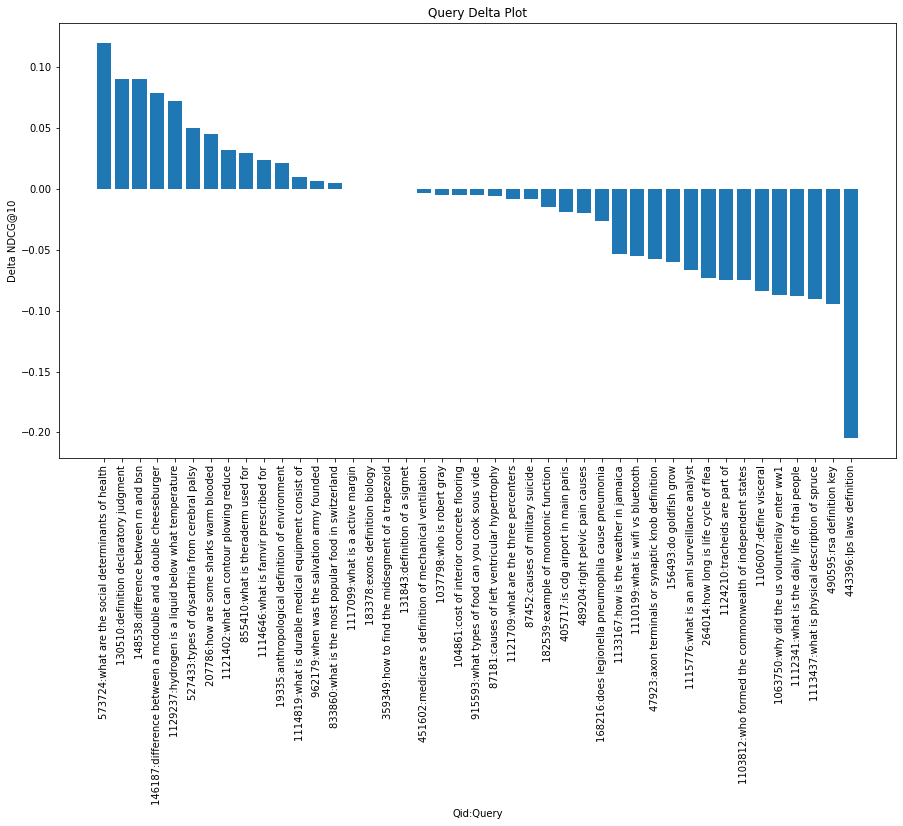

In [34]:
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.bar(sorted_cls_similarity_df["qid:query"], sorted_cls_similarity_df["delta"])
plt.title("Query Delta Plot")
plt.xlabel("Qid:Query")
plt.ylabel("Delta NDCG@10")
plt.xticks(rotation=90)

In [35]:
print("Improved Queries: ", sorted_cls_similarity_df[sorted_cls_similarity_df['delta']>0].count()[0])
print("Negative Impact Queries: ", sorted_cls_similarity_df[sorted_cls_similarity_df['delta']<0].count()[0])
print("Unchanged Queries: ", sorted_cls_similarity_df[sorted_cls_similarity_df['delta']==0].count()[0])

Improved Queries:  14
Negative Impact Queries:  25
Unchanged Queries:  4
